# 장바구니 분석 Basket analysis

참고 도서: Building ML system with Python

장바구니 분석은 추천 시스템의 또 다른 방법을 제시합니다. (항상 평점 데이터를 얻을 수 있는 것이 아니다!)

장바구니 정보로는 사용자가 사고 나서 후회를 했는지 얼마나 좋아했는지 알 길이 없습니다.
하지만 많은 양의 데이터를 쉽게 얻을 수 있습니다.


## 슈퍼마켓 쇼핑 장바구니 분석

벨기에 슈퍼마켓에서 익명의 트랜잭셔으로 구성된 데이터셋을 실습에 사용하겠습니다.

In [111]:
from collections import defaultdict
from itertools import chain

import gzip

In [112]:
dataset = [[int(tok) for tok in line.strip().split()]
              for line in gzip.open('../data/recommand/retail.dat.gz')]

가저온 데이터를 살펴보겠습니다.

In [113]:
len(dataset), dataset[20:30]

(88162,
 [[119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133],
  [48, 134, 135, 136],
  [39, 48, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
  [39, 150, 151, 152],
  [38, 39, 56, 153, 154, 155],
  [48, 156, 157, 158, 159, 160],
  [39, 41, 48],
  [161, 162, 163, 164, 165, 166, 167],
  [38, 39, 48, 168, 169, 170, 171, 172, 173],
  [32, 39, 41, 48, 174, 175, 176, 177, 178]])

숫자들은 구매 목록에 대한 id 인 것 같습니다.  한 리스트로 묶여진 아이템은 동일한 장바구니에서 구매된 것으로 해석합니다.

데이터의 크기는 8.8만개 정도입니다..

장바구니에 같은 품목이 중복되어 들어가 있는 경우 중복을 제거합니다.

In [114]:
dataset = [set(items) for items in dataset]

각 물품이 얼마나 자주 구매되었는지 세어봅니다.

아래는 아이템의 출현 빈도를 세는 코드로 파이썬에서 이디엄처럼 사용합니다.

In [117]:
from itertools import chain

counts = defaultdict(int)
for elem in chain(*dataset):
    counts[elem] += 1

가장 많이 구매된 순서대로 물품 구매 횟수를 정리해서  그래프를 그려보겠습니다.

In [118]:
count_val = [count for key, count in counts.items()]

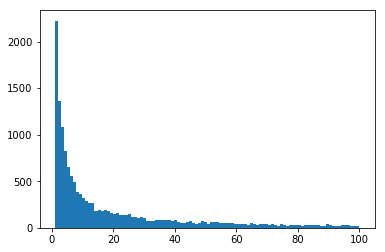

In [119]:
import matplotlib.pyplot as plt

plt.hist(count_val, bins=100, range=(1, 100))
plt.show()

많은 제품들이 한 두 번만 구매되고 있는 현상을 발견할 수 있습니다.
33% 의 제품이 4번 이하로 구매되었지만 이들은 전체 구매량중의 1% 정도밖에 되질 않습니다. (이 수치는 책은 내용으로 검증은 하지 않았습니다.)
이런 현상은 long tail 이라고 부릅니다.


## 데이터 줄이기

8 만개의 데이터는 개인 컴퓨터에서 훈련시키기 힘들었습니다.
1 만개로 줄여서 사용하겠습니다.

데이터를 선별해서 추출하고 원래의 데이터 타입으로 만드는 과정이 간단하지는 않았습니다.

In [133]:
import numpy as np

train_idx = np.random.permutation(len(dataset))[:10000]
print('Size of training set : ', len(train_idx))

Size of training set :  10000


In [134]:
dataset_small = np.atleast_2d(dataset)[:,train_idx].ravel()

In [135]:
type(dataset_small), dataset_small.shape

(numpy.ndarray, (10000,))

In [136]:
dataset_small = list(dataset_small)
dataset = dataset_small

새로운 데이터를 구성을 얻었으니 아이템 빈도수를 다시 계산합니다.

In [138]:
counts = defaultdict(int)
for elem in chain(*dataset_small):
    counts[elem] += 1

## 장바구니 분석 알고리즘

장바구니 분석에서 먼저 얻고 싶은 데이터는 장바구니의 트랜잭션 집합의 부분집합이 N 번 이상 나오는 부분집합입니다.

이 실습에서는 장바구니 분석에서 클래식한 Apriori 알고리즘을 사용하겠습니다.

아프리오리 알고리즘에서는 아이템의 연관관계 가능성을 탐색할 때 항목집합 갯수를 를 줄이는(pruning) 방법을 사용합니다.

bottom-up 접근법으로 가장 작은 후보 집합으로부터 계산을 시작하며,
일정 빈도수 이상 출현하지 않는 집합은 자주 등장하는 집합 세트에서 제외합니다.

In [139]:
# support 는 함꼐 구매되는 물품 집합의 횟수

minsupport = 100

# minsupport 이상 구매된 단일 품목
valid = set(k for k,v in counts.items() if (v >= minsupport))

최소 support 를 넘는 원소하 하나인 집합 valid 를 계산했습니다.

itemsets 는 valid의 원소로부터 만든 각각의 frozenset (immutalbe) 의 리스트입니다.

In [140]:
itemsets = [frozenset([v]) for v in valid]

In [141]:
len(itemsets), itemsets[0]

(73, frozenset({258}))

In [142]:
# min_support 이상 출현한 부분집합의 리스트 (단, 크기 2 이상)
freqsets = []

# 장바구니 목록이 최대 16개인 경우까지 부분집합을 계산함
for i in range(16):
    # 각 루프에서 새로 추가할 부분 집합
    nextsets = []
    
    # 각 루푸에서의 중복되는 부분집합을 걸러니기 위한 set
    tested = set()
    
    # 모든 가능한 집합에 대해서 순환합니다.
    for it in itemsets:
        # 추가될 가능성이 있는 원소에 대해서 순환합니다.
        for v in valid:
            # 만약 현재 조사하는 집합에 추가 가능성이 있는 원소가 없다면
            if v not in it:
                # 그 원소를 추가해서 새 집합을 만듭니다.
                c = (it | frozenset([v]))
                if c in tested:
                    continue
                tested.add(c)
                # 새로 만든 집합에 대한 서포트를 계산합니다.
                support_c = sum(1 for d in dataset_small if 
                               d.issuperset(c))
                if support_c > minsupport:
                    nextsets.append(c)
    freqsets.extend(nextsets)
    itemsets = nextsets
    if not len(itemsets):
        break
print('Finished!')
                

Finished!


## Association rule mining

frequent itemsets 자체로는 유요하게 사용할 수 없습니다.

다음 단계는 association rule 을 만드는 것입니다.

연관률이란 A 를 사면  B 도 산다 라는 식의 표현입니다.  물론 확률의 의미가 담긴 표현입니다.

여기서 lift 라고 하는 확률적 측정치를 소개합니다.

$lift(X \rightarrow Y) = \frac{P(X|Y)}{P(Y)} = \frac{P(X\cap Y)}{P(X)P(Y)} $

lift라고 새로 명명하긴 했지만 확률적으로는 친숙한 개념입니다.

Y 라는 사건이 일어났을 떄 X 라는 사건이 전제되었을 확률을 개산한 것 입니다.

베스트 셀러 구매의 경우에 P(Y) 도 커지고 P(Y|X) 도 커져서 lift 는 1에 가까운 값이 됩니다.  이 룰은 적절하지 않다고 판단합니다.

실제로는 리프트 값이 10 이상이길 바랍니다. (아마도 100 이상)


아래의 코드는 위에서 구한 부분집합에 대해서 부분집합의 한 원소가 빠진 상태의 경우 그 원소의 추가를 사후 사건으로 규정했을 때의 Lift 값을 구하고 Lift 값이 5 이상인 경우를 출력하는 내용입니다.

In [146]:
minlift = 5.0

for itemset in freqsets:
    for item in itemset:
        
        # 추천할 아이템 후보
        consequent = frozenset([item])
        
        # 선행사건, 추천할 아이템을 후보를 제외한 집합
        antecedent = itemset - consequent
        
        base = 0.0
        # 선행사건을 카운팅
        acount = 0.0
        # 후행사건을 카운팅
        ccount = 0.0
        
        for d in dataset:
            if item in d: base += 1
            if d.issuperset(itemset): ccount += 1
            if d.issuperset(antecedent): acount += 1
        base /= len(dataset)
        p_y_given_x = ccount / acount
        lift = p_y_given_x / base
        if lift > minlift:
            print('Rule {0} -> {1} has lift {2}'
                     .format(antecedent, consequent, lift))
                

Rule frozenset({286}) -> frozenset({38}) has lift 5.530323153764756
Rule frozenset({38}) -> frozenset({286}) has lift 5.530323153764756
Rule frozenset({38}) -> frozenset({36}) has lift 5.37804383535282
Rule frozenset({36}) -> frozenset({38}) has lift 5.37804383535282
Rule frozenset({38}) -> frozenset({37}) has lift 5.613958837005043
Rule frozenset({37}) -> frozenset({38}) has lift 5.613958837005042
Rule frozenset({38}) -> frozenset({170}) has lift 5.54991288646486
Rule frozenset({170}) -> frozenset({38}) has lift 5.54991288646486
Rule frozenset({38}) -> frozenset({110}) has lift 5.513778377319299
Rule frozenset({110}) -> frozenset({38}) has lift 5.513778377319298
Rule frozenset({38, 39}) -> frozenset({36}) has lift 5.518649942234693
Rule frozenset({36, 39}) -> frozenset({38}) has lift 5.425619572795842
Rule frozenset({48, 36}) -> frozenset({38}) has lift 5.262867342620025
Rule frozenset({38, 39}) -> frozenset({170}) has lift 6.055796859338456
Rule frozenset({170, 39}) -> frozenset({38}

30개 정도의 룰이 얻어졌습니다.

위의 결과에서 가장 Lift 가 높은 경우는 아이템 {38,39} 를 구매한 경우 아이템 {170}을 추가로 구매하는 경우로  리프트 값이 6.0 입니다.
